# Lab-8 CSL304
### Name: Saurav Gupta
### Id: 12341940

## Campus Placement Bayesian Network

This notebook implements a Bayesian network model for campus placement analysis. The model captures relationships between:

- Academic performance (CGPA)
- Technical skills 
- Soft skills
- Written test performance
- Interview performance
- Final job offer outcome

The network structure shows how these factors influence each other in the placement process.

In [68]:
# imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# pgmpy imports
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

# Utilities
from math import log
np.random.seed(42)


In [69]:
#Define model structure (Directed edges)
# Variables: C (CGPA), T (Technical), S (Soft), W (Written test), I (Interview), J (Job offer)
edges = [
    ('C', 'W'),  # CGPA -> Written
    ('T', 'W'),  # Tech -> Written
    ('T', 'I'),  # Tech -> Interview
    ('S', 'I'),  # Soft -> Interview
    ('W', 'J'),  # Written -> Job
    ('I', 'J')   # Interview -> Job
]

model = DiscreteBayesianNetwork(edges)


In [70]:
# Root node CPDs (state_names used for clarity)
cpd_C = TabularCPD(
    variable='C', variable_card=3,
    values=[[0.2], [0.5], [0.3]],
    state_names={'C': ['Low', 'Medium', 'High']}
)

cpd_T = TabularCPD(
    variable='T', variable_card=2,
    values=[[0.4], [0.6]],
    state_names={'T': ['Weak', 'Strong']}
)

cpd_S = TabularCPD(
    variable='S', variable_card=2,
    values=[[0.5], [0.5]],
    state_names={'S': ['Weak', 'Strong']}
)

model.add_cpds(cpd_C, cpd_T, cpd_S)


In [71]:
# Conditional CPDs (follow the column-order note from assignment)

# Written Test: W | C, T
# evidence order in assignment: evidence=['C','T'] with evidence_card=[3,2]
written_cpd = TabularCPD(
    variable='W', variable_card=2,
    values=[
        [0.8, 0.6, 0.3, 0.4, 0.2, 0.1],  # W = Fail
        [0.2, 0.4, 0.7, 0.6, 0.8, 0.9]   # W = Pass
    ],
    evidence=['C', 'T'],
    evidence_card=[3, 2],
    state_names={
        'W': ['Fail', 'Pass'],
        'C': ['Low', 'Medium', 'High'],
        'T': ['Weak', 'Strong']
    }
)

# Interview: I | T, S
interview_cpd = TabularCPD(
    variable='I', variable_card=2,
    values=[
        [0.7, 0.4, 0.3, 0.1],  # I = Fail
        [0.3, 0.6, 0.7, 0.9]   # I = Pass
    ],
    evidence=['T', 'S'],
    evidence_card=[2, 2],
    state_names={
        'I': ['Fail', 'Pass'],
        'T': ['Weak', 'Strong'],
        'S': ['Weak', 'Strong']
    }
)

# Job Offer: J | W, I
offer_cpd = TabularCPD(
    variable='J', variable_card=2,
    values=[
        [0.99, 0.8, 0.6, 0.1],  # J = No
        [0.01, 0.2, 0.4, 0.9]   # J = Yes
    ],
    evidence=['W', 'I'],
    evidence_card=[2, 2],
    state_names={
        'J': ['No', 'Yes'],
        'W': ['Fail', 'Pass'],
        'I': ['Fail', 'Pass']
    }
)

model.add_cpds(written_cpd, interview_cpd, offer_cpd)


In [72]:
# model check & print CPDs
print("Model check (should be True):", model.check_model())
print("\nCPDs in model:")
for cpd in model.get_cpds():
    print(cpd)
    print("-----")


Model check (should be True): True

CPDs in model:
+-----------+-----+
| C(Low)    | 0.2 |
+-----------+-----+
| C(Medium) | 0.5 |
+-----------+-----+
| C(High)   | 0.3 |
+-----------+-----+
-----
+-----------+-----+
| T(Weak)   | 0.4 |
+-----------+-----+
| T(Strong) | 0.6 |
+-----------+-----+
-----
+-----------+-----+
| S(Weak)   | 0.5 |
+-----------+-----+
| S(Strong) | 0.5 |
+-----------+-----+
-----
+---------+---------+-----------+-----------+-----------+---------+-----------+
| C       | C(Low)  | C(Low)    | C(Medium) | C(Medium) | C(High) | C(High)   |
+---------+---------+-----------+-----------+-----------+---------+-----------+
| T       | T(Weak) | T(Strong) | T(Weak)   | T(Strong) | T(Weak) | T(Strong) |
+---------+---------+-----------+-----------+-----------+---------+-----------+
| W(Fail) | 0.8     | 0.6       | 0.3       | 0.4       | 0.2     | 0.1       |
+---------+---------+-----------+-----------+-----------+---------+-----------+
| W(Pass) | 0.2     | 0.4      

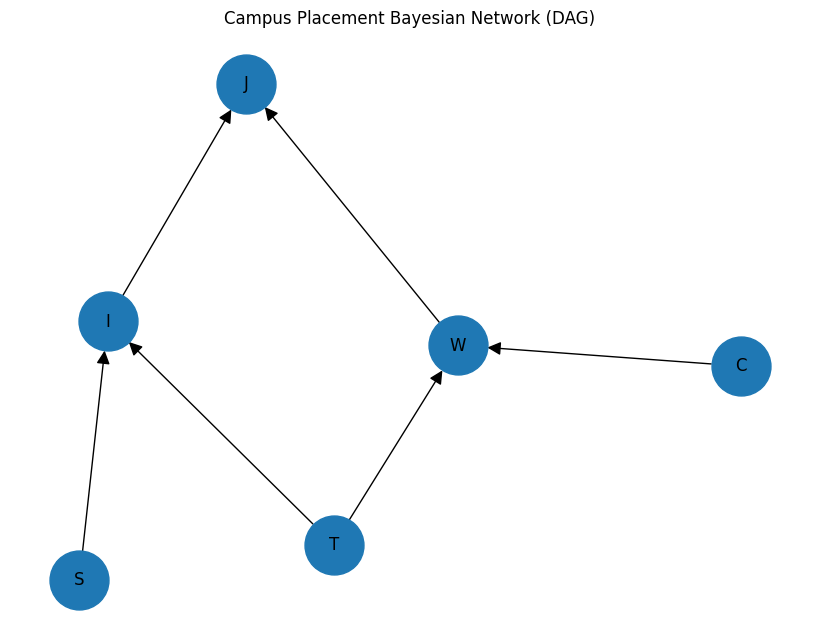

In [73]:
# Visualize the network (DAG)
plt.figure(figsize=(8,6))
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1800, arrowsize=20)
plt.title("Campus Placement Bayesian Network (DAG)")
plt.show()


In [74]:
# Setup VariableElimination for inference
infer = VariableElimination(model)


In [75]:
# Run the required queries and print nicely

def show_query(var, evidence=None):
    q = infer.query(variables=[var], evidence=evidence, show_progress=False)
    print(f"Query: P({var}" + (f" | {evidence}" if evidence else "") + ")")
    print(q)
    print("-" * 50)

# 1. Baseline P(J)
show_query('J')

# 2. Predictive: P(J | C='High', T='Strong')
show_query('J', evidence={'C': 'High', 'T': 'Strong'})

# 3. Diagnostic: P(T | J='Yes')
show_query('T', evidence={'J': 'Yes'})

# 4a. Explaining-away: P(W='Pass' | J='Yes')
show_query('W', evidence={'J': 'Yes'})

# 4b. Explaining-away: P(W='Pass' | J='Yes', I='Pass')
show_query('W', evidence={'J': 'Yes', 'I': 'Pass'})


Query: P(J)
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.4823 |
+--------+----------+
| J(Yes) |   0.5177 |
+--------+----------+
--------------------------------------------------
Query: P(J | {'C': 'High', 'T': 'Strong'})
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.2638 |
+--------+----------+
| J(Yes) |   0.7362 |
+--------+----------+
--------------------------------------------------
Query: P(T | {'J': 'Yes'})
+-----------+----------+
| T         |   phi(T) |
+===========+==========+
| T(Weak)   |   0.3316 |
+-----------+----------+
| T(Strong) |   0.6684 |
+-----------+----------+
--------------------------------------------------
Query: P(W | {'J': 'Yes'})
+---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.0930 |
+---------+----------+
| W(Pass) |   0.9070 |
+---------+----------+
--------------------------------------------------
Query: P(W | {'J': 'Yes', 'I': 'Pass'})
+--

**Explaining-away analysis (brief):**

We're interested in P(W='Pass' | J='Yes') and P(W='Pass' | J='Yes', I='Pass').

Because J has two parents W and I (v-structure W → J ← I), when we observe the child J='Yes', W and I become dependent (they "explain away" each other). Adding the evidence I='Pass' typically *reduces* the amount of explanatory power needed from W: if we already know I passed, the posterior probability that W passed given J may decrease or increase depending on the CPTs — intuition: if I passing already explains why J='Yes', then W is less necessary to explain J, so P(W='Pass' | J='Yes', I='Pass') will often be lower than P(W='Pass' | J='Yes'). We'll compute the actual numbers above and comment in the report.


In [76]:
# Sampling and parameter learning
sampler = BayesianModelSampling(model)
n_samples = 20000
data = sampler.forward_sample(size=n_samples, seed=42, show_progress=False)

# Convert state names to match string labels (pgmpy sampling returns pandas with categories)
# data already uses the state names by default. Print first few rows:
print("Sampled data (first 10 rows):")
print(data.head(10))

# Create a new model with structure only and fit parameters from data
learned_model = DiscreteBayesianNetwork(edges)
# Fit with BayesianEstimator (adds pseudo counts) — can also try MaximumLikelihoodEstimator
learned_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")

# Print learned CPD for J (P(J | W, I)) and compare with original
print("\nOriginal P(J | W, I):")
print(offer_cpd)
print("\nLearned P(J | W, I):")
learned_offer_cpd = learned_model.get_cpds('J')
print(learned_offer_cpd)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C': 'C', 'W': 'C', 'T': 'C', 'I': 'C', 'S': 'C', 'J': 'C'}


Sampled data (first 10 rows):
        C     W       T     I       S    J
0  Medium  Fail  Strong  Pass    Weak   No
1    High  Pass    Weak  Pass    Weak  Yes
2    High  Pass    Weak  Fail    Weak  Yes
3  Medium  Pass  Strong  Pass    Weak  Yes
4     Low  Pass  Strong  Fail    Weak   No
5     Low  Fail  Strong  Pass    Weak   No
6     Low  Pass  Strong  Pass    Weak  Yes
7    High  Pass    Weak  Fail    Weak   No
8  Medium  Fail  Strong  Pass  Strong   No
9    High  Pass    Weak  Fail    Weak   No

Original P(J | W, I):
+--------+---------+---------+---------+---------+
| W      | W(Fail) | W(Fail) | W(Pass) | W(Pass) |
+--------+---------+---------+---------+---------+
| I      | I(Fail) | I(Pass) | I(Fail) | I(Pass) |
+--------+---------+---------+---------+---------+
| J(No)  | 0.99    | 0.8     | 0.6     | 0.1     |
+--------+---------+---------+---------+---------+
| J(Yes) | 0.01    | 0.2     | 0.4     | 0.9     |
+--------+---------+---------+---------+---------+

Learned P(J | 

In [77]:
# Compare CPDs numerically using KL divergence per column
def kl_divergence(p, q, eps=1e-12):
    p = np.asarray(p) + eps
    q = np.asarray(q) + eps
    return np.sum(p * np.log(p / q))

def compare_cpds(original_cpd, learned_cpd):
    """
    Both inputs are pgmpy TabularCPD objects. We compare column-wise (over variable states).
    """
    # original values: shape (var_card, ncols)
    orig_vals = np.array(original_cpd.get_values())
    learned_vals = np.array(learned_cpd.get_values())

    # columns correspond to same evidence ordering if both created with same state_names and evidence ordering
    ncols = orig_vals.shape[1]
    kls = []
    for col in range(ncols):
        p = orig_vals[:, col]
        q = learned_vals[:, col]
        kls.append(kl_divergence(p, q))
    return kls

print("\nKL divergences for P(J|W,I) columns (small is better):")
kls = compare_cpds(offer_cpd, learned_offer_cpd)
for i, val in enumerate(kls):
    print(f"Column {i}: KL = {val:.6f}")
print("Note: KL close to 0 means learned CPD matches original well (with 20000 samples).")



KL divergences for P(J|W,I) columns (small is better):
Column 0: KL = 0.000261
Column 1: KL = 0.094858
Column 2: KL = 0.090866
Column 3: KL = 0.000000
Note: KL close to 0 means learned CPD matches original well (with 20000 samples).


In [78]:
# save the sampled dataset to CSV for inspection/submission
data.to_csv("campus_placement_samples_20000.csv", index=False)
print("Saved sampled data to campus_placement_samples_20000.csv")


Saved sampled data to campus_placement_samples_20000.csv
